In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from time_series_experiments import utils
from time_series_experiments.utils import metrics
from time_series_experiments.utils import scalers
from time_series_experiments import baseline
from time_series_experiments import transformer

tf.get_logger().setLevel('ERROR')

In [ ]:
en_df = pd.read_csv('https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/nyc_energy.csv')
en_df = en_df[~pd.isnull(en_df['demand'])]

In [3]:
seed = 0xC0FFEE
fdw = 168
fw = 24

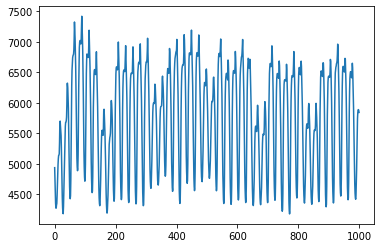

In [4]:
y = en_df['demand'].values

plt.plot(np.arange(y[:1000].shape[0]), y[:1000])

x_train_idx, y_train_idx, x_test_idx, y_test_idx = utils.train_test_split_index(
    y.shape[0], fdw, fw, test_size=0.1, random_seed=seed
)

x_train = np.expand_dims(y[x_train_idx], axis=-1)
y_train = y[y_train_idx]
x_test = np.expand_dims(y[x_test_idx], axis=-1)
y_test = y[y_test_idx]

In [5]:
x_train.shape

(44040, 168, 1)

In [6]:
baseline_model = baseline.LatestNaiveBaseline(fw=fw)
y_pred_baseline = baseline_model.predict(x_test)
print('RMSE', metrics.rmse(y_test, y_pred_baseline))

RMSE 1176.90810254767


In [7]:
scaler = scalers.MeanScaler()

xtr = scaler.fit_transform(x_train)
ytr = scaler.transform(y_train)
dec_inp = utils.create_decoder_inputs(ytr, go_token=0)

attention_dim = 32
num_heads = 8
epochs = 10
batch_size = 64

model = transformer.Transformer(
    num_layers=1,
    attention_dim=attention_dim,
    num_heads=num_heads,
    hidden_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    attention_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    pwffn_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    output_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
)

model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

history = model.fit([xtr, dec_inp], ytr, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/10
620/620 [==============================] - 388s 626ms/step - loss: 0.1722 - val_loss: 0.0772
Epoch 2/10
620/620 [==============================] - 378s 609ms/step - loss: 0.0525 - val_loss: 0.0275
Epoch 3/10
620/620 [==============================] - 372s 600ms/step - loss: 0.0392 - val_loss: 0.0237
Epoch 4/10
620/620 [==============================] - 371s 598ms/step - loss: 0.0346 - val_loss: 0.0254
Epoch 5/10
620/620 [==============================] - 368s 594ms/step - loss: 0.0258 - val_loss: 0.0139
Epoch 6/10
620/620 [==============================] - 367s 592ms/step - loss: 0.0243 - val_loss: 0.0298
Epoch 7/10
620/620 [==============================] - 374s 603ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 8/10
620/620 [==============================] - 375s 604ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 9/10
620/620 [==============================] - 380s 612ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 10/10
620/620 [==============================] - 387s 624m

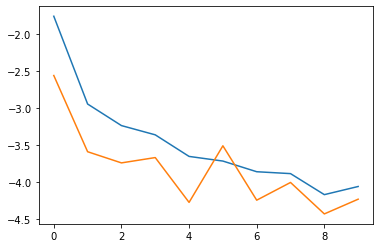

In [8]:
plot_y1 = np.array(history.history['loss'])
plot_y2 = np.array(history.history['val_loss'])
plot_x = np.arange(plot_y1.shape[0])
plt.plot(plot_x, np.log(plot_y1))
plt.plot(plot_x, np.log(plot_y2))

In [9]:
scaler = scalers.MeanScaler()
xt = scaler.fit_transform(x_test)
dec_inp = utils.create_empty_decoder_inputs(xt.shape[0], 0)

y_pred, weights = model.predict([xt, dec_inp])
y_pred = scaler.inverse_transform(y_pred)

print('RMSE', metrics.rmse(y_test, y_pred)) 
print('MASE', metrics.mase(y_test, y_pred, y_pred_baseline))

RMSE 1380.1329401009714
MASE 1.1249852222521526


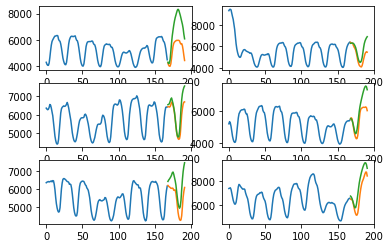

In [10]:
fig, axes = plt.subplots(3, 2)
axes = [item for sublist in axes for item in sublist]

indexes = np.random.choice(np.arange(y_pred.shape[0]), len(axes))

for i, ax in zip(indexes, axes): 
    plot_x = np.squeeze(x_test[i])
    plot_y_pred = np.squeeze(y_pred[i])
    plot_y = np.squeeze(y_test[i])
    
    plot_x_numbers = np.arange(0, plot_x.shape[0])
    plot_y_numbers = np.arange(plot_x.shape[0], plot_x.shape[0] + plot_y.shape[0])

    ax.plot(plot_x_numbers, plot_x)
    ax.plot(plot_y_numbers, plot_y)
    ax.plot(plot_y_numbers, plot_y_pred)

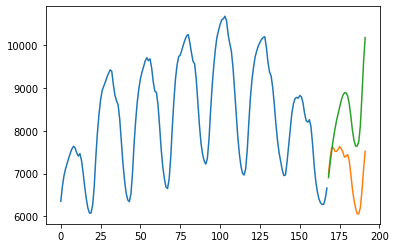

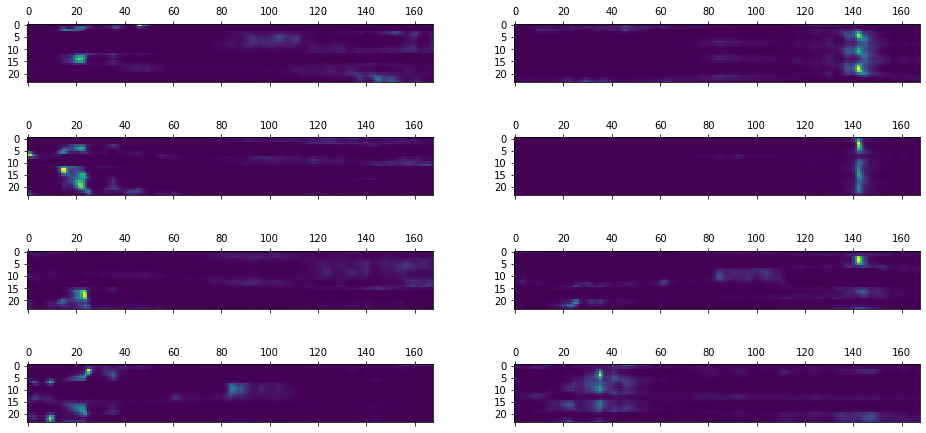

In [15]:
def plot_weights(attention, x, y):     
    fig = plt.figure(figsize=(16, 8))
    
    for i in range(attention.shape[0]):
        ax = fig.add_subplot(4, 2, i+1)
        head_attn = attention[i]
        ax.matshow(head_attn, cmap='viridis')
        
#         ax.set_xticks(range(len(x)))
#         ax.set_yticks(range(len(y)))
        
random = np.random.randint(y_pred.shape[0])

plot_x = np.arange(x_test[random].shape[0] + y_pred[random].shape[0])
plt.plot(plot_x[0:x_test[random].shape[0]], x_test[random])
plt.plot(plot_x[-y_pred[random].shape[0]:], y_test[random])
plt.plot(plot_x[-y_pred[random].shape[0]:], y_pred[random])

plot_weights(weights['encoder_decoder_attention'][0][random], x_test[random], y_pred[random])